## Imports

In [2]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [3]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [4]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = dset.ImageFolder('../Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('../Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('../Dataset/test', transform=transform)

In [5]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Creating MobileNet model

In [12]:
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier.add_module("fc", nn.Linear(1000, 172))
optimizer = optim.Adam(model.parameters())
print(model)
model = gpu(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Training the model

In [13]:
def train_model(model, optimizer, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        batches = train_dataloader
        num_correct, num_samples, total_loss = 0, 0, 0
        i = 0
        for x, y in batches:
            if i % 100 == 0:
                print("Iteration {}".format(i))
            x, y = gpu(x), gpu(y)
            scores = model(x)
            loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
            i += 1
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(x), gpu(y)                
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [14]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, epochs=20)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Epoch: 1 Training Loss: 0.0379 Got 29732 / 66071 correct. Acc: 45.00%
Epoch: 1 Validation Loss: 0.0308 Got 5889 / 11016 correct 53.46%
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Epoch: 2 Training Loss: 0.0327 Got 34953 / 66071 correct. Acc: 52.90%
Epoch: 2 Validation Loss: 0.0306 Got 6123 / 11016 correct 55.58%
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Epoch: 3 Training Loss: 0.0321 Got 35988 / 66071 correct. Acc: 54.47%
Epoch: 3 Validation Loss: 0.0311 Got 6223 / 11016 correct 56.49%
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 90

In [15]:
# Save the model.
PATH = "../saved_models/food/mobilenet/mobilenet.dat"
torch.save(model, PATH)
torch.save({'loss': LOSS, 'acc': ACC, 'loss_v': LOSS_V, 'acc_v': ACC_V}, '../saved_models/food/mobilenet/mobilenet-history.pt')

## Evaluation

In [7]:
# Load the model.
PATH = "../saved_models/food/mobilenet/mobilenet.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/mobilenet/mobilenet-history.pt')
LOSS, ACC, LOSS_V, ACC_V = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

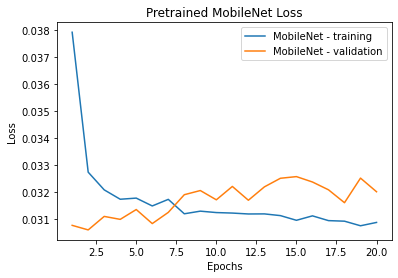

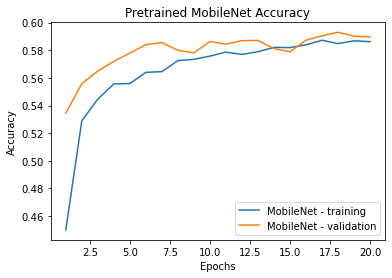

In [8]:
# Loss and Accuracy Curves
from utils.plots import plot_loss_and_accuracy_curves
plot_loss_and_accuracy_curves('MobileNet', LOSS, ACC, LOSS_V, ACC_V)

In [9]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Top 1 Accuracy of the network on the all test images: 58.79 %


In [10]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = labels[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 83.61 %


In [11]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [12]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(labels.cpu().numpy().tolist())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)
print(cnf_matrix[0][0], sum(cnf_matrix[0]))

Confusion Matrix

[[171   7   0 ...   0   1   0]
 [  3 199   0 ...   0   0   0]
 [  0   1  58 ...   0   0   0]
 ...
 [  0   0   0 ...  56   1   0]
 [  1   0   0 ...   2  38   1]
 [  0   0   0 ...   0   0 143]]
171 307


In [ ]:
# Visualizing the confusion matrix 

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(172)],
                  columns = [i for i in range(172)])
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

<AxesSubplot:>

In [ ]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report

FOOD_LIST_PATH = '../VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()
classes = train_dataset.classes
class_names = list(map(lambda x : food_names[int(x) - 1], classes))
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=class_names))